# 일반 모델의 변수 중요도
- Permutation Feature Importance


# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# 데이터 불러오기

In [2]:
data = pd.read_csv('./data/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

# 필요한 함수 정의하기

In [4]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

# 데이터 준비하기

##### x,y 나누기

In [5]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

##### 가변수화

boston 데이터의 경우 가변수화 할 데이터는 없다.

##### train, validation 분할

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2023)
x_train.shape

(404, 12)

##### 스케일링 하기

In [8]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

# PFI

* model1 : SVM
* model2 : DL

In [9]:
from sklearn.inspection import permutation_importance

## 1. SVM 모델

In [10]:
model1 = SVR()
model1.fit(x_train_s, y_train)

SVR()

* permutation feature importance 구하기

In [11]:
pfi1 = permutation_importance(model1, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2022)

In [12]:
pfi1

{'importances_mean': array([ 6.21354042e-03,  1.87716843e-02,  3.42943791e-02, -1.44759741e-04,
         1.67538797e-02,  1.43620243e-01,  3.42723156e-02,  5.06414154e-02,
         5.73247882e-02,  6.88105302e-02,  9.10701382e-02,  1.82203955e-01]),
 'importances_std': array([0.00415539, 0.00553379, 0.01359334, 0.01163574, 0.00732933,
        0.017704  , 0.01051839, 0.01956881, 0.01585942, 0.01950559,
        0.01019782, 0.02322485]),
 'importances': array([[ 0.00349409,  0.00295555,  0.00494415,  0.00391552,  0.01539104,
          0.00524425,  0.0115478 ,  0.00205961,  0.00338629,  0.0091971 ],
        [ 0.01871508,  0.0297427 ,  0.01739854,  0.01058815,  0.01981834,
          0.01754539,  0.0231646 ,  0.0143042 ,  0.01211491,  0.02432493],
        [ 0.05020081,  0.02222796,  0.02340253,  0.02666903,  0.04809604,
          0.03890465,  0.05797022,  0.0123674 ,  0.0330162 ,  0.03008895],
        [ 0.02821797,  0.00078349, -0.01501127, -0.00125959, -0.00094478,
         -0.01415904, -0.

* feature별 Score 분포

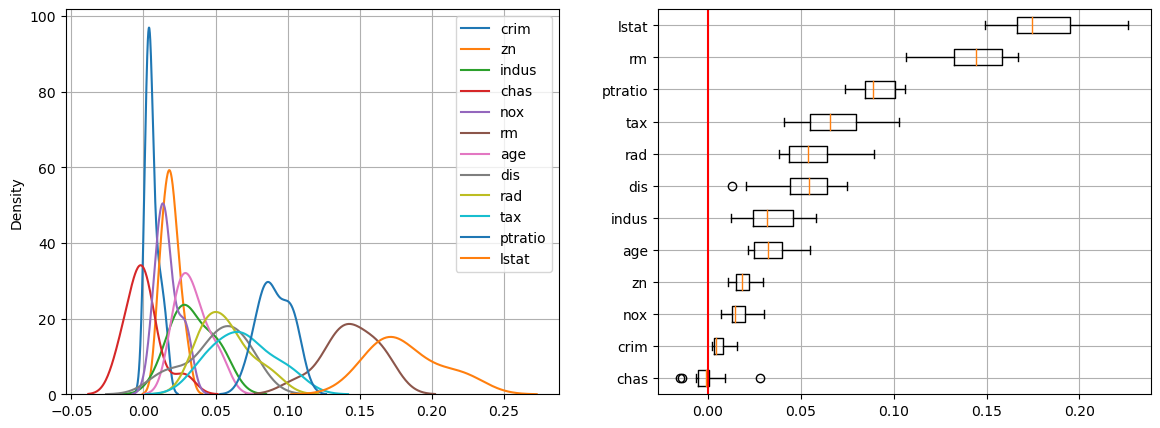

In [13]:
plot_PFI(pfi1, x.columns)

* 평균값으로 변수중요도 그래프 그리기

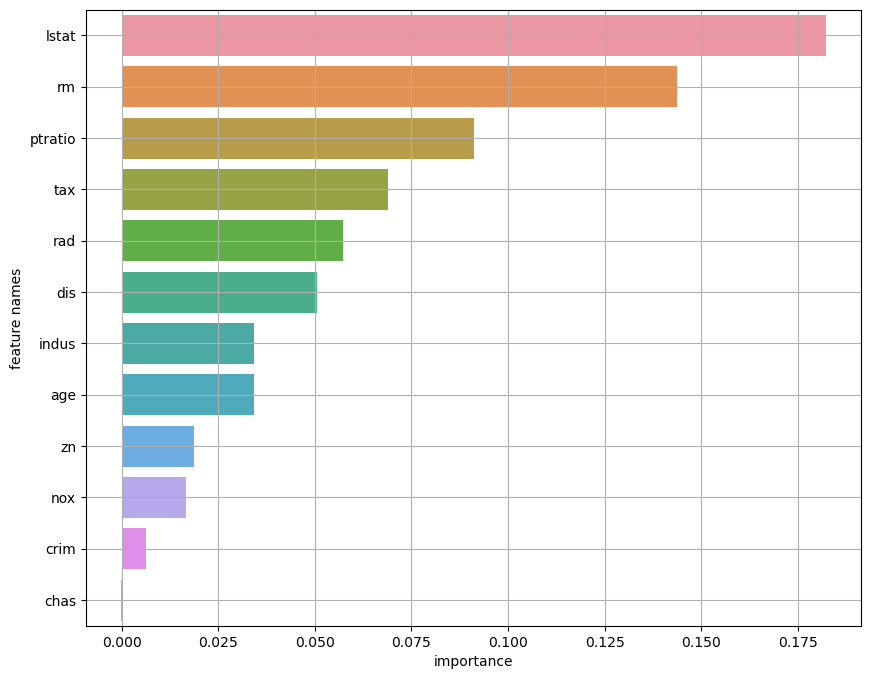

In [14]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

## Deap Learning 모델

In [15]:
x_train_s.shape[1]

12

In [17]:
nfeatures = x_train_s.shape[1]
clear_session()

model2 = Sequential([Dense(32, input_shape = [nfeatures,], activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(1)
                     ])

model2.compile(optimizer = 'adam', loss = 'mse')
history = model2.fit(x_train_s, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 575.3277 - val_loss: 510.5421
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 563.5635 - val_loss: 497.8276
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 550.4682 - val_loss: 483.2115
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 535.0305 - val_loss: 465.2951
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 515.6710 - val_loss: 443.3715
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 491.9698 - val_loss: 416.7982
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 463.8398 - val_loss: 385.5199
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 430.4987 - val_loss: 349.3075
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 392.2496 - val_loss: 310.0740
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - lo

Epoch 81/100
11/11 [==============================] - 0s 9ms/step - loss: 30.4212 - val_loss: 55.0006
Epoch 82/100
11/11 [==============================] - 0s 9ms/step - loss: 29.8223 - val_loss: 52.9416
Epoch 83/100
11/11 [==============================] - 0s 9ms/step - loss: 29.3121 - val_loss: 51.8970
Epoch 84/100
11/11 [==============================] - 0s 9ms/step - loss: 28.8131 - val_loss: 51.9960
Epoch 85/100
11/11 [==============================] - 0s 9ms/step - loss: 28.3532 - val_loss: 51.5109
Epoch 86/100
11/11 [==============================] - 0s 8ms/step - loss: 28.0195 - val_loss: 51.4761
Epoch 87/100
11/11 [==============================] - 0s 8ms/step - loss: 27.6478 - val_loss: 52.4824
Epoch 88/100
11/11 [==============================] - 0s 8ms/step - loss: 27.1924 - val_loss: 51.3265
Epoch 89/100
11/11 [==============================] - 0s 8ms/step - loss: 26.6095 - val_loss: 50.5319
Epoch 90/100
11/11 [==============================] - 0s 9ms/step - loss: 26.3541 

* permutation feature importance 구하기
    * deep learning 모델에 대해서는 명시적으로 scoring = 'r2'을 지정해 줘야 합니다.

In [19]:
pfi2 = permutation_importance(model2, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2023)

4/4 [==============================] - 0s 2ms/step


In [20]:
pfi2

{'importances_mean': array([ 0.01228023,  0.02696725, -0.00081433,  0.03482531,  0.00978227,
         0.24958051,  0.06602138, -0.01803646,  0.01421431,  0.05278264,
         0.01752829,  0.28546035]),
 'importances_std': array([0.01149274, 0.01346026, 0.00337483, 0.00843994, 0.00543738,
        0.05142249, 0.01702064, 0.00956415, 0.00530977, 0.0216878 ,
        0.00457793, 0.04827473]),
 'importances': array([[ 0.01110162, -0.00560998,  0.00959022,  0.01207894,  0.00070392,
          0.02707651,  0.02803076, -0.00207655,  0.02510788,  0.016799  ],
        [ 0.02622713,  0.0266742 ,  0.01503659,  0.01900625,  0.02517827,
          0.0029618 ,  0.05615197,  0.03380093,  0.03824523,  0.02639018],
        [ 0.00091985, -0.00764406, -0.00231797, -0.00230176, -0.00448841,
          0.00315426,  0.00320147, -0.00206126,  0.00203074,  0.00136385],
        [ 0.04729691,  0.0437799 ,  0.03342021,  0.03268838,  0.01877263,
          0.03806129,  0.04380666,  0.02533261,  0.02932673,  0.03576777]

* feature별 Score 분포

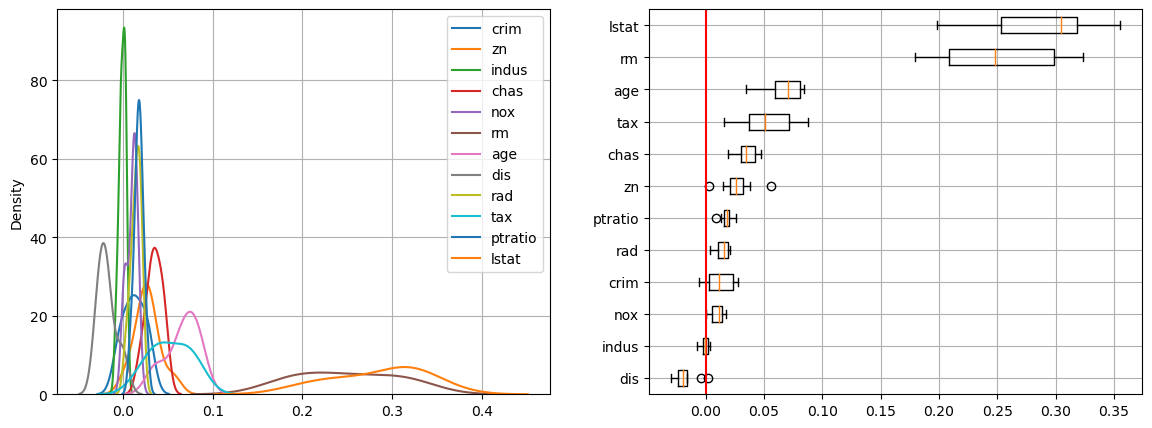

In [21]:
plot_PFI(pfi2, x.columns)

* 평균값으로 변수중요도 그래프 그리기

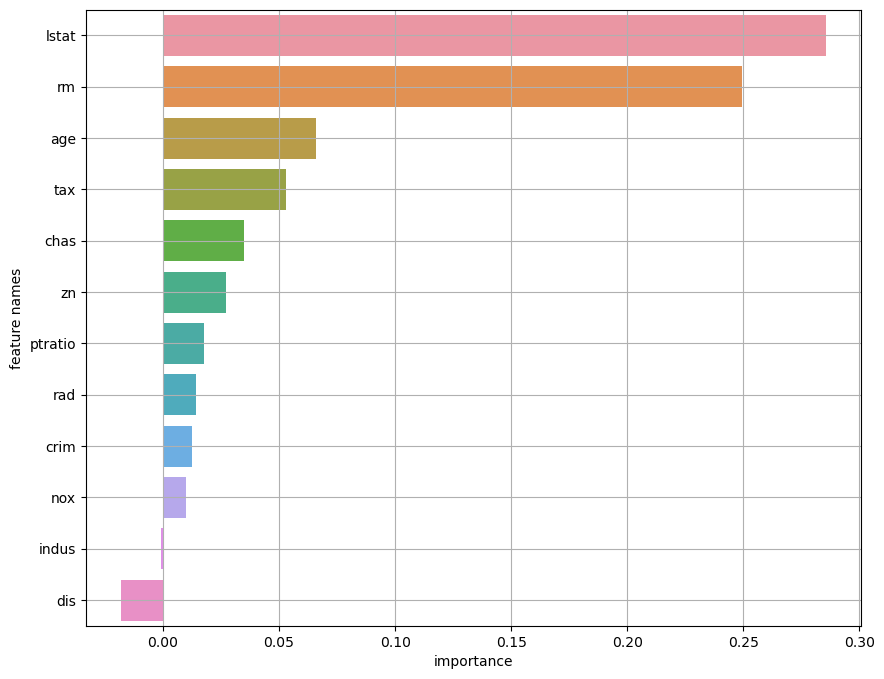

In [22]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

In [23]:
from sklearn.metrics import *

In [24]:
pred1 = model1.predict(x_val_s)
print(mean_absolute_error(y_val, pred1))

3.8053672980428654


In [25]:
pred2 = model2.predict(x_val_s)
print(mean_absolute_error(y_val, pred2))

4/4 [==============================] - 0s 2ms/step
4.198476467880549
